## Aim
Classify MNIST dataset using a deep neural network (on Pytorch).

In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

## Preprocessing
### Loading


In [34]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
train_len = 50000 #int(len(train_data)*0.85)
valid_len = 10000 #int(len(train_data)*0.15)

train_data, valid_data = torch.utils.data.random_split(train_data, [train_len,valid_len])

test_data = datasets.MNIST(root='data', train=False,
                                download=True, transform = transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          num_workers=num_workers, shuffle=True)

loaders = {'train':train_loader, 'valid':valid_loader, 'test':test_loader}
# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(valid_data))
print('Num test images: ', len(test_data))

Num training images:  50000
Num validation images:  10000
Num test images:  10000


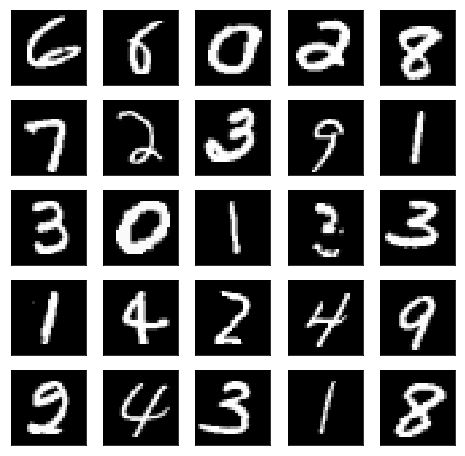

In [35]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(1,26):
    ax = fig.add_subplot(5, 5, idx, xticks=[], yticks=[])
    plt.imshow(images[idx][0,:,:], cmap="gray")
    
plt.show()

## Model
### Create

In [53]:
from torch import nn, optim
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [54]:
# instantiate the CNN
model = Net()
use_cuda=False
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


### Train

In [61]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001, weight_decay =0.01)

In [62]:
# model_scratch.load_state_dict(torch.load('model_scratch.pt'))
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            #clear the gradients of all optimized variables
            optimizer.zero_grad()
            #forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #calculate the batch loss
            loss = criterion(output, target)
            #backward pass: compute gradient of the loss with respect to model paramters
            loss.backward()
            #perform a single optimization step (parameter update)
            optimizer.step()
            #update training loss
#             train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
    
            if batch_idx % 20 == 19:    # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                      (epoch, batch_idx + 1, train_loss / 20))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            #forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            #calculate the batch loss
            loss = criterion(output, target)
            #update the validation loss
#             valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        #calculate average losses
        train_loss_ = train_loss/len(loaders['train'].dataset)
        valid_loss_ = valid_loss/len(loaders['valid'].dataset)

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss_,
            valid_loss_
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss_ <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss_))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss_
            
    # return trained model
    return model

In [63]:
# train the model
model = train(40, loaders, model, optimizer, 
                      criterion, use_cuda, 'model_mnist.pt')

# # load the model that got the best validation accuracy
model.load_state_dict(torch.load('model_mnist.pt'))

Epoch 1, Batch 20 loss: 0.0029313538689166
Epoch 1, Batch 40 loss: 0.0029163858853281
Epoch 1, Batch 60 loss: 0.0028929323889315
Epoch 1, Batch 80 loss: 0.0026696848217398
Epoch 1, Batch 100 loss: 0.0026091430336237
Epoch 1, Batch 120 loss: 0.0026106676086783
Epoch 1, Batch 140 loss: 0.0026875957846642
Epoch 1, Batch 160 loss: 0.0027570670936257
Epoch 1, Batch 180 loss: 0.0027459631673992
Epoch 1, Batch 200 loss: 0.0027682287618518
Epoch 1, Batch 220 loss: 0.0028255579527467
Epoch 1, Batch 240 loss: 0.0029102852568030
Epoch 1, Batch 260 loss: 0.0029334968421608
Epoch 1, Batch 280 loss: 0.0029942912515253
Epoch 1, Batch 300 loss: 0.0031187408603728
Epoch 1, Batch 320 loss: 0.0031788672786206
Epoch 1, Batch 340 loss: 0.0032331501133740
Epoch 1, Batch 360 loss: 0.0032529954332858
Epoch 1, Batch 380 loss: 0.0033220401965082
Epoch 1, Batch 400 loss: 0.0033901003189385
Epoch 1, Batch 420 loss: 0.0035093936603516
Epoch 1, Batch 440 loss: 0.0035872862208635
Epoch 1, Batch 460 loss: 0.003680596

Epoch 5, Batch 500 loss: 0.0082768332213163
Epoch 5, Batch 520 loss: 0.0082514025270939
Epoch 5, Batch 540 loss: 0.0082641215994954
Epoch 5, Batch 560 loss: 0.0082535594701767
Epoch 5, Batch 580 loss: 0.0082643311470747
Epoch 5, Batch 600 loss: 0.0082799885421991
Epoch 5, Batch 620 loss: 0.0082471864297986
Epoch 5, Batch 640 loss: 0.0082471873611212
Epoch 5, Batch 660 loss: 0.0082498202100396
Epoch 5, Batch 680 loss: 0.0082481391727924
Epoch 5, Batch 700 loss: 0.0082372976467013
Epoch 5, Batch 720 loss: 0.0082098823040724
Epoch 5, Batch 740 loss: 0.0081783151254058
Epoch 5, Batch 760 loss: 0.0082055665552616
Epoch 5, Batch 780 loss: 0.0081882961094379
Epoch: 5 	Training Loss: 0.000003 	Validation Loss: 0.000018
Epoch 6, Batch 20 loss: 0.0072178519330919
Epoch 6, Batch 40 loss: 0.0072610815986991
Epoch 6, Batch 60 loss: 0.0078203957527876
Epoch 6, Batch 80 loss: 0.0079558137804270
Epoch 6, Batch 100 loss: 0.0080248378217220
Epoch 6, Batch 120 loss: 0.0080009745433927
Epoch 6, Batch 140 

Epoch 10, Batch 200 loss: 0.0076394416391850
Epoch 10, Batch 220 loss: 0.0077324742451310
Epoch 10, Batch 240 loss: 0.0076592974364758
Epoch 10, Batch 260 loss: 0.0076631107367575
Epoch 10, Batch 280 loss: 0.0076954611577094
Epoch 10, Batch 300 loss: 0.0077062696218491
Epoch 10, Batch 320 loss: 0.0076708681881428
Epoch 10, Batch 340 loss: 0.0077042751945555
Epoch 10, Batch 360 loss: 0.0077602290548384
Epoch 10, Batch 380 loss: 0.0077852318063378
Epoch 10, Batch 400 loss: 0.0078425165265799
Epoch 10, Batch 420 loss: 0.0078135374933481
Epoch 10, Batch 440 loss: 0.0077887303195894
Epoch 10, Batch 460 loss: 0.0077638877555728
Epoch 10, Batch 480 loss: 0.0077408151701093
Epoch 10, Batch 500 loss: 0.0077420836314559
Epoch 10, Batch 520 loss: 0.0076829204335809
Epoch 10, Batch 540 loss: 0.0076396153308451
Epoch 10, Batch 560 loss: 0.0076080849394202
Epoch 10, Batch 580 loss: 0.0075948201119900
Epoch 10, Batch 600 loss: 0.0075827180407941
Epoch 10, Batch 620 loss: 0.0075926845893264
Epoch 10, 

Epoch 14, Batch 600 loss: 0.0074958316981792
Epoch 14, Batch 620 loss: 0.0075122872367501
Epoch 14, Batch 640 loss: 0.0074963131919503
Epoch 14, Batch 660 loss: 0.0075054154731333
Epoch 14, Batch 680 loss: 0.0075285681523383
Epoch 14, Batch 700 loss: 0.0075198099948466
Epoch 14, Batch 720 loss: 0.0075166737660766
Epoch 14, Batch 740 loss: 0.0075304070487618
Epoch 14, Batch 760 loss: 0.0075122080743313
Epoch 14, Batch 780 loss: 0.0074952617287636
Epoch: 14 	Training Loss: 0.000003 	Validation Loss: 0.000015
Validation loss decreased (0.000015 --> 0.000015).  Saving model ...
Epoch 15, Batch 20 loss: 0.0070587312802672
Epoch 15, Batch 40 loss: 0.0069287358783185
Epoch 15, Batch 60 loss: 0.0068533411249518
Epoch 15, Batch 80 loss: 0.0068918904289603
Epoch 15, Batch 100 loss: 0.0070513086393476
Epoch 15, Batch 120 loss: 0.0070975855924189
Epoch 15, Batch 140 loss: 0.0072043561376631
Epoch 15, Batch 160 loss: 0.0071910666301847
Epoch 15, Batch 180 loss: 0.0071350261569023
Epoch 15, Batch 20

Epoch 19, Batch 160 loss: 0.0073524392209947
Epoch 19, Batch 180 loss: 0.0073425038717687
Epoch 19, Batch 200 loss: 0.0073069347999990
Epoch 19, Batch 220 loss: 0.0073057436384261
Epoch 19, Batch 240 loss: 0.0073791914619505
Epoch 19, Batch 260 loss: 0.0073962532915175
Epoch 19, Batch 280 loss: 0.0073877042159438
Epoch 19, Batch 300 loss: 0.0074208751320839
Epoch 19, Batch 320 loss: 0.0074778860434890
Epoch 19, Batch 340 loss: 0.0075214742682874
Epoch 19, Batch 360 loss: 0.0074630221351981
Epoch 19, Batch 380 loss: 0.0074399970471859
Epoch 19, Batch 400 loss: 0.0073531894013286
Epoch 19, Batch 420 loss: 0.0073678037151694
Epoch 19, Batch 440 loss: 0.0073758857324719
Epoch 19, Batch 460 loss: 0.0073305754922330
Epoch 19, Batch 480 loss: 0.0074036694131792
Epoch 19, Batch 500 loss: 0.0074419295415282
Epoch 19, Batch 520 loss: 0.0074298218823969
Epoch 19, Batch 540 loss: 0.0074181230738759
Epoch 19, Batch 560 loss: 0.0074160308577120
Epoch 19, Batch 580 loss: 0.0074030742980540
Epoch 19, 

Epoch 23, Batch 580 loss: 0.0073007405735552
Epoch 23, Batch 600 loss: 0.0073013552464545
Epoch 23, Batch 620 loss: 0.0073241801001132
Epoch 23, Batch 640 loss: 0.0073440792039037
Epoch 23, Batch 660 loss: 0.0073364204727113
Epoch 23, Batch 680 loss: 0.0073129669763148
Epoch 23, Batch 700 loss: 0.0073027960024774
Epoch 23, Batch 720 loss: 0.0072926930151880
Epoch 23, Batch 740 loss: 0.0073085604235530
Epoch 23, Batch 760 loss: 0.0073018036782742
Epoch 23, Batch 780 loss: 0.0072933919727802
Epoch: 23 	Training Loss: 0.000003 	Validation Loss: 0.000015
Validation loss decreased (0.000015 --> 0.000015).  Saving model ...
Epoch 24, Batch 20 loss: 0.0068174102343619
Epoch 24, Batch 40 loss: 0.0068896063603461
Epoch 24, Batch 60 loss: 0.0067790532484651
Epoch 24, Batch 80 loss: 0.0069411955773830
Epoch 24, Batch 100 loss: 0.0070849410258234
Epoch 24, Batch 120 loss: 0.0071457787416875
Epoch 24, Batch 140 loss: 0.0071343267336488
Epoch 24, Batch 160 loss: 0.0071725794114172
Epoch 24, Batch 18

Epoch 28, Batch 180 loss: 0.0073699518106878
Epoch 28, Batch 200 loss: 0.0073222480714321
Epoch 28, Batch 220 loss: 0.0074305729940534
Epoch 28, Batch 240 loss: 0.0073669790290296
Epoch 28, Batch 260 loss: 0.0073175430297852
Epoch 28, Batch 280 loss: 0.0073035955429077
Epoch 28, Batch 300 loss: 0.0073551177047193
Epoch 28, Batch 320 loss: 0.0072619626298547
Epoch 28, Batch 340 loss: 0.0072495127096772
Epoch 28, Batch 360 loss: 0.0071960673667490
Epoch 28, Batch 380 loss: 0.0071536800824106
Epoch 28, Batch 400 loss: 0.0071076177991927
Epoch 28, Batch 420 loss: 0.0070475190877914
Epoch 28, Batch 440 loss: 0.0070272600278258
Epoch 28, Batch 460 loss: 0.0069765760563314
Epoch 28, Batch 480 loss: 0.0069316090084612
Epoch 28, Batch 500 loss: 0.0069550261832774
Epoch 28, Batch 520 loss: 0.0069876848720014
Epoch 28, Batch 540 loss: 0.0069858757779002
Epoch 28, Batch 560 loss: 0.0069988900795579
Epoch 28, Batch 580 loss: 0.0069920113310218
Epoch 28, Batch 600 loss: 0.0070034214295447
Epoch 28, 

Epoch 32, Batch 540 loss: 0.0069883293472230
Epoch 32, Batch 560 loss: 0.0070112445391715
Epoch 32, Batch 580 loss: 0.0070382319390774
Epoch 32, Batch 600 loss: 0.0070504010654986
Epoch 32, Batch 620 loss: 0.0070281527005136
Epoch 32, Batch 640 loss: 0.0070370333269238
Epoch 32, Batch 660 loss: 0.0070340074598789
Epoch 32, Batch 680 loss: 0.0070657096803188
Epoch 32, Batch 700 loss: 0.0070432834327221
Epoch 32, Batch 720 loss: 0.0070437728427351
Epoch 32, Batch 740 loss: 0.0070378379896283
Epoch 32, Batch 760 loss: 0.0070418976247311
Epoch 32, Batch 780 loss: 0.0070384866558015
Epoch: 32 	Training Loss: 0.000003 	Validation Loss: 0.000015
Epoch 33, Batch 20 loss: 0.0071096653118730
Epoch 33, Batch 40 loss: 0.0069814957678318
Epoch 33, Batch 60 loss: 0.0067069320939481
Epoch 33, Batch 80 loss: 0.0068228794261813
Epoch 33, Batch 100 loss: 0.0066490271128714
Epoch 33, Batch 120 loss: 0.0067156767472625
Epoch 33, Batch 140 loss: 0.0068811527453363
Epoch 33, Batch 160 loss: 0.00698849698528

Epoch 37, Batch 160 loss: 0.0073035159148276
Epoch 37, Batch 180 loss: 0.0073193847201765
Epoch 37, Batch 200 loss: 0.0072818025946617
Epoch 37, Batch 220 loss: 0.0072623142041266
Epoch 37, Batch 240 loss: 0.0073105795308948
Epoch 37, Batch 260 loss: 0.0073574818670750
Epoch 37, Batch 280 loss: 0.0072343396022916
Epoch 37, Batch 300 loss: 0.0072271814569831
Epoch 37, Batch 320 loss: 0.0071762017905712
Epoch 37, Batch 340 loss: 0.0071540540084243
Epoch 37, Batch 360 loss: 0.0071184858679771
Epoch 37, Batch 380 loss: 0.0071337088011205
Epoch 37, Batch 400 loss: 0.0071293944492936
Epoch 37, Batch 420 loss: 0.0070923017337918
Epoch 37, Batch 440 loss: 0.0071288296021521
Epoch 37, Batch 460 loss: 0.0071241571567953
Epoch 37, Batch 480 loss: 0.0071012279950082
Epoch 37, Batch 500 loss: 0.0071287518367171
Epoch 37, Batch 520 loss: 0.0071421773172915
Epoch 37, Batch 540 loss: 0.0070965485647321
Epoch 37, Batch 560 loss: 0.0070875273086131
Epoch 37, Batch 580 loss: 0.0070808148011565
Epoch 37, 

In [64]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [65]:
# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 0.135707


Test Accuracy: 96% (9633/10000)
